In [ ]:
!pip install kaggle

from google.colab import drive
drive.mount('/content/drive')

import os
import json
f = open("/content/drive/MyDrive/kaggle/token/kaggle.json", 'r')
json_data = json.load(f) 
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

!kaggle competitions download -c titanic -p /content/drive/MyDrive/kaggle/titanic/dataset

!unzip -o /content/drive/MyDrive/kaggle/titanic/dataset/titanic.zip -d /content/drive/MyDrive/kaggle/titanic/dataset

!rm /content/drive/MyDrive/kaggle/titanic/dataset/titanic.zip

# Task
* Input
  * passenger information
* Output
  * classify survived or not survived (0 or 1)

# Import library

In [ ]:
# Reference:
# https://www.kaggle.com/startupsci/titanic-data-science-solutions

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Prepare dataset

In [ ]:
# read data
train_df = pd.read_csv('/content/drive/MyDrive/kaggle/titanic/dataset/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/kaggle/titanic/dataset/test.csv')

display(train_df.head())
display(train_df.tail())
display(test_df.head())
display(test_df.tail())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


# Check basic information

In [ ]:
# abstract info
display(train_df.info()) # train data contains null value in 'age', 'cabin', and 'embarked'
display(test_df.info()) # test data contains null in 'age', 'fare', and 'cabin'

# statistical info
display(train_df.describe())
display(train_df.describe(include=['O'])) # show object data (str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


None

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [ ]:
# survival mean rate on each data
display(train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False))
display(train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False))
display(train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False))
display(train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False))

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


,Sex,Survived
0,female,0.742038
1,male,0.188908


,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


# Delete unrelated features

In [ ]:
# drop features 
print("Before", train_df.shape, test_df.shape)

train_df = train_df.drop(['Ticket', 'Cabin', 'Name', 'PassengerId', 'Age'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin', 'Name',  'Age'], axis=1)

combine = [train_df, test_df] # passing by reference

print("After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before (891, 12) (418, 11)
After (891, 7) (418, 7) (891, 7) (418, 7)


# Feature cleansing

In [ ]:
# gender
# binarization on combine[0] (train) and combine[1] (test)
for dataset in combine: 
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    
# embarked (the place where the passengers have ridden on)
# acquire mode value from train data
freq_port = train_df.Embarked.dropna().mode()[0]

# put mode value into NaN
for dataset in combine: 
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
# binarization
for dataset in combine: 
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

# fare
# acquire median value from train data
med_fare = train_df.Fare.dropna().median()

# put median value into NaN
for dataset in combine: 
    dataset['Fare'] = dataset['Fare'].fillna(med_fare)

# Make new feature

In [ ]:
# define familiy size
for dataset in combine: 
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine: 
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize']==1, 'IsAlone'] = 1 # if FamilySize==1, put 1 to IsAlone

In [ ]:
group_names = [0, 1, 2, 3]

for dataset in combine: 
    dataset['Fare'] = pd.qcut(dataset['Fare'], 4, labels=group_names)

# display(train_df)
display(combine[0])

train_df = train_df.drop(['SibSp', 'Parch', 'FamilySize'], axis=1)
test_df = test_df.drop(['SibSp', 'Parch', 'FamilySize'], axis=1)
display(train_df)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
0,0,3,0,1,0,0,0,2,0
1,1,1,1,1,0,3,1,2,0
2,1,3,1,0,0,1,0,1,1
3,1,1,1,1,0,3,0,2,0
4,0,3,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...
886,0,2,0,0,0,1,0,1,1
887,1,1,1,0,0,2,0,1,1
888,0,3,1,1,2,2,0,4,0
889,1,1,0,0,0,2,1,1,1


,Survived,Pclass,Sex,Fare,Embarked,IsAlone
0,0,3,0,0,0,0
1,1,1,1,3,1,0
2,1,3,1,1,0,1
3,1,1,1,3,0,0
4,0,3,0,1,0,1
...,...,...,...,...,...,...
886,0,2,0,1,0,1
887,1,1,1,2,0,1
888,0,3,1,2,0,0
889,1,1,0,2,1,1


In [ ]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 5), (891,), (418, 5))

(891, 5)


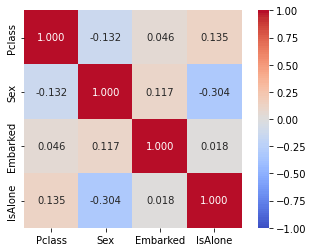

In [ ]:
# check correlation
df_corr = X_train.corr()
sns.heatmap(df_corr, vmin=-1, vmax=1, annot=True, fmt='0.3f', cmap=sns.color_palette('coolwarm', 100), square=True);

print(X_train.shape)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model

n_input = 5
n_hidden = 128
n_out = 1

model = Sequential() # declare using Sequential
model.add(Dense(n_hidden, input_dim=n_input)) 
model.add(Activation("sigmoid"))
model.add(Dense(n_hidden))
model.add(Activation("sigmoid"))
model.add(Dense(n_out))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

# display(plot_model(model, show_shapes=True))


In [ ]:
history = model.fit(X_train.values, Y_train.values, epochs=100, batch_size=8) 
score = model.evaluate(X_train.values, Y_train.values, verbose=1)

Epoch 1/100
112/112 [==============================] - 3s 8ms/step - loss: 0.6528 - accuracy: 0.6274
Epoch 2/100
112/112 [==============================] - 1s 8ms/step - loss: 0.5909 - accuracy: 0.6846
Epoch 3/100
112/112 [==============================] - 1s 8ms/step - loss: 0.5479 - accuracy: 0.7194
Epoch 4/100
112/112 [==============================] - 1s 8ms/step - loss: 0.5038 - accuracy: 0.7553
Epoch 5/100
112/112 [==============================] - 1s 5ms/step - loss: 0.4957 - accuracy: 0.7520
Epoch 6/100
112/112 [==============================] - 1s 7ms/step - loss: 0.4849 - accuracy: 0.7666
Epoch 7/100
112/112 [==============================] - 1s 5ms/step - loss: 0.4774 - accuracy: 0.7868
Epoch 8/100
112/112 [==============================] - 1s 8ms/step - loss: 0.4714 - accuracy: 0.7744
Epoch 9/100
112/112 [==============================] - 1s 6ms/step - loss: 0.4720 - accuracy: 0.7834
Epoch 10/100
112/112 [==============================] - 1s 7ms/step - loss: 0.4712 - accura

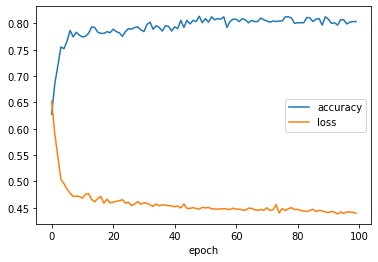

In [ ]:
plt.plot(history.epoch, history.history["accuracy"], label="accuracy")
plt.plot(history.epoch, history.history["loss"], label="loss")
plt.xlabel("epoch")
plt.legend()

In [ ]:
# References:
# https://qiita.com/maskot1977/items/b2cfb369f60ad02887b0
# https://qiita.com/Ishotihadus/items/c2f864c0cde3d17b7efb

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

78.56

In [ ]:
# Support Vector Machines
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

80.92

In [ ]:
# kNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

80.47

In [ ]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

77.33

In [ ]:
# Perceptron
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

69.7

In [ ]:
# Linear SVC
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

78.56

In [ ]:
# Stochastic Gradient Descent
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

68.69

In [ ]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

82.15

In [ ]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

82.15

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,82.15
8,Decision Tree,82.15
0,Support Vector Machines,80.92
1,KNN,80.47
2,Logistic Regression,78.56
7,Linear SVC,78.56
4,Naive Bayes,77.33
5,Perceptron,69.70
6,Stochastic Gradient Decent,68.69


In [ ]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
display(submission)
submission.to_csv("/content/drive/MyDrive/kaggle/titanic/dataset/titanic_submission.csv", index=False)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
!kaggle competitions submit -c titanic -f "/content/drive/MyDrive/kaggle/titanic/dataset/titanic_submission.csv" -m "titanic submission"

100% 2.77k/2.77k [00:00<00:00, 10.7kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster